Compression Ratio: 1.3029339098894317
MSE: 10530.9181936028
PSNR: 7.90614121778318
Rate Distortion: 6.13998909636091


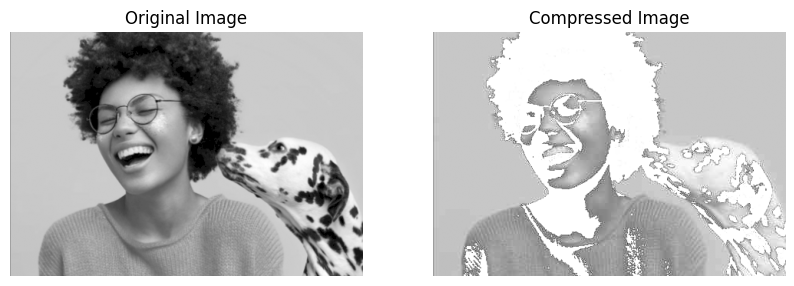

In [4]:
import cv2
import numpy as np
import heapq
import math
from collections import Counter
import matplotlib.pyplot as plt

# ============================
# HUFFMAN CODING
# ============================

class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq


def build_huffman_tree(image):
    pixels = image.flatten()
    freq = Counter(pixels)

    heap = [HuffmanNode(sym, fr) for sym, fr in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)

        merged = HuffmanNode(freq=n1.freq + n2.freq)
        merged.left = n1
        merged.right = n2
        heapq.heappush(heap, merged)

    return heap[0], freq


def generate_codes(node, code="", codes={}):
    if node:
        if node.symbol is not None:
            codes[node.symbol] = code
        generate_codes(node.left, code + "0", codes)
        generate_codes(node.right, code + "1", codes)
    return codes


# ============================
# JPEG-LIKE DCT COMPRESSION
# ============================

def dct2(block):
    return cv2.dct(np.float32(block))


def idct2(block):
    return cv2.idct(block)


def jpeg_compress(image, q=50):
    original_h, original_w = image.shape

    # Calculate padding needed
    pad_h = (8 - original_h % 8) % 8
    pad_w = (8 - original_w % 8) % 8

    # Pad the image
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w)), 'edge')

    h, w = padded_image.shape
    padded_image = padded_image - 128
    compressed = np.zeros((h, w))

    Q = np.array([
        [16,11,10,16,24,40,51,61],
        [12,12,14,19,26,58,60,55],
        [14,13,16,24,40,57,69,56],
        [14,17,22,29,51,87,80,62],
        [18,22,37,56,68,109,103,77],
        [24,35,55,64,81,104,113,92],
        [49,64,78,87,103,121,120,101],
        [72,92,95,98,112,100,103,99]
    ])

    Q = Q * (100 / q)

    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = padded_image[i:i+8, j:j+8]
            dct_block = dct2(block)
            quant = np.round(dct_block / Q)
            dequant = quant * Q
            compressed[i:i+8, j:j+8] = idct2(dequant)

    compressed = compressed + 128
    # Remove padding before returning
    return np.clip(compressed[:original_h, :original_w], 0, 255)


# ============================
# METRICS
# ============================

def mse(original, compressed):
    return np.mean((original - compressed) ** 2)


def psnr(mse_val):
    if mse_val == 0:
        return float('inf')
    return 10 * math.log10((255 ** 2) / mse_val)


def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size


# ============================
# MAIN
# ============================

image = cv2.imread("image11.jpeg", cv2.IMREAD_GRAYSCALE)

# Huffman
tree, freq = build_huffman_tree(image)
codes = generate_codes(tree)

encoded_bits = sum(freq[p] * len(codes[p]) for p in freq)

# JPEG Compression
compressed_img = jpeg_compress(image)

# Metrics
mse_val = mse(image, compressed_img)
psnr_val = psnr(mse_val)

original_size = image.size * 8
compressed_size = encoded_bits

CR = compression_ratio(original_size, compressed_size)
RD = compressed_size / image.size

print("Compression Ratio:", CR)
print("MSE:", mse_val)
print("PSNR:", psnr_val)
print("Rate Distortion:", RD)

# Display
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Compressed Image")
plt.imshow(compressed_img, cmap='gray')
plt.axis('off')

plt.show()